### Lesson 18 Demo: Modeling in time series in statsmodels (45 mins)

To explore time series models, we will continue with the Rossmann sales data.  This dataset has sales data for every Rossmann store for a 3-year period, as well as indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time.  Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

In [1]:
%matplotlib inline
import pandas as pd
# Load the data and set the DateTime index
data = pd.read_csv('../data/rossmann.csv', skipinitialspace=True, low_memory=False)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [2]:
# Filter to Store 1
store1_data = data[data.Store == 1]

In [3]:
# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

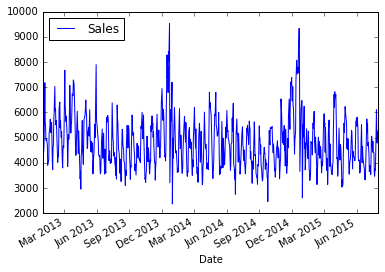

In [4]:
# Plot the sales over time
store1_open_data[['Sales']].plot()

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [5]:
print store1_data.Sales.autocorr(lag=1) # -0.13
print store1_data.Sales.autocorr(lag=2) # -0.03

-0.127325143391
-0.0347871557079


We do see some minimal correlation in time, implying an AR model can be useful. An easier way to diagnose this may be to plot many autocorrelations at once.

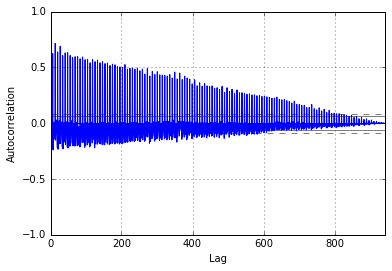

In [6]:
%matplotlib inline
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(store1_data.Sales)

This shows a typical pattern of an autocorrelation plot - it should decrease to 0 as lag increases! However, it's hard to observe exactly what the values are.

We will use `statsmodels` to code AR, MA, ARMA and ARIMA models.

`statsmodels` is a machine learning package, similar to `sckit-learn`.  While it lacks many of the features of `scikit-learn` for evaluation and production level models, it does include many more niche statistical models, including time series models. It also provides a nice summary utility to help diagnose models.

`statsmodels` also has a better autocorrelation plot, which can look at fixed numbers of lag values.

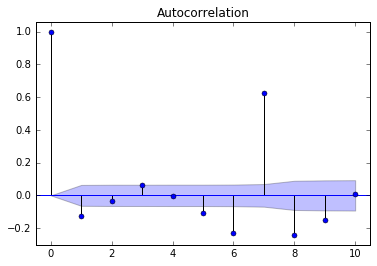

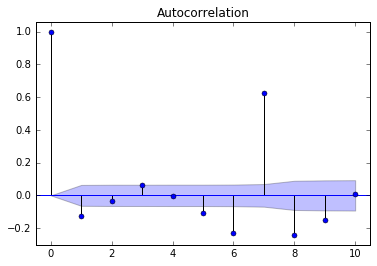

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(store1_data.Sales, lags=10)

Here we observe autocorrelation at 10 lag values. 1 and 2 are what we saw before. This implies a small, but limited impact based on the last few values, suggesting that an autoregressive model might be useful.

**We also observe a larger spike at 7 - what does that mean?**

If we observed a handful of randomly distributed spikes - that would imply a MA model may be useful. This is because those random spikes suggest that at some point in time, something changed in the world and all values are shifted up down from there in a fixed way.

That may be the case here, but if we expand the window we can see that the spikes occur regularly at 7 days windows. This means we have a weekly cycle!


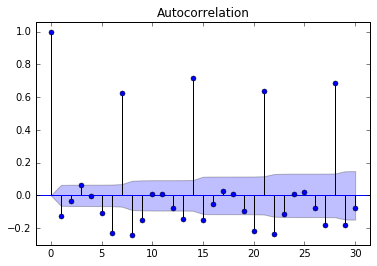

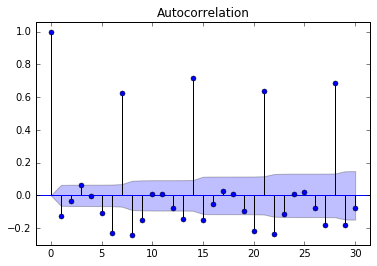

In [8]:
plot_acf(store1_data.Sales, lags=30)

Let's start by investigating AR models.
### AR, MA and ARMA models in Statsmodels

To explore AR and ARMA models, we will use `sm.tsa.ARMA`. Remember, an ARMA model is a combination of autoregressive and moving average models.

We can train an autoregressive model by turning off the moving average component (setting q = 0).

By passing the `(1, 0)` in the second argument, we are fitting an ARMA model as ARMA(p=1, q=0). Remember, an ARMA(p, q) model is AR(p) + MA(q). This means that an ARMA(1, 0) is the same as an AR(1) model.

In this AR(1) model we learn an intercept value, or base sales values. Additionally, we learn a coefficient that tells us how to include the last sales values. In this case, we take the intercept of ~4700 and add in the previous months sales * 0.68.

Note the coefficient here does not match the lag 1 autocorrelation - implying the the data is not stationary.

We can learn an AR(2) model, which regresses each sales value on the last two, with the following:


In [9]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Thu, 17 Nov 2016   AIC                          12540.651
Time:                        19:34:03   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.8515     82.985     57.394      0.000      4600.205  4925.498
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

In [10]:
model = ARMA(store1_sales_data, (2, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Thu, 17 Nov 2016   AIC                          12542.063
Time:                        19:36:34   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.9851     85.262     55.863      0.000      4595.875  4930.095
ar.L1.Sales     0.6634      0.036     18.537      0.000         0.593     0.734
ar.L2.Sales     0.0274      0.036      0.767      0.443        -0.043     0.098
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4235           +0.0000j            1.4235            0.0000
AR.2          -25.5915           +0.0000j           25.5915            0.5000
-----------------------------------------------------------------------------
"""

Here we learn two coefficients, which tells us the effect of the last two sales values on current sales. To make a sales prediction for a future month, we would combine the last two months of sales with the weights or coefficients learned.

While this model may be able to better model the series, it may be more difficult to interpret.

To start to diagnose the model, we want to look at the _residuals_.

**Check:** What are residuals? In linear regression, what did we expect of residuals?

_Residuals_ are the errors of the model, or a measure of how off our prior predictions were.

What we ideally want are randomly distributed errors that are fairly small. If the errors are large then clearly that would be problematic. If the errors have a pattern, particularly over time, then we have overlooked something in the model or certain periods of time are different than the rest of the dataset.

We can plot the residuals as below:

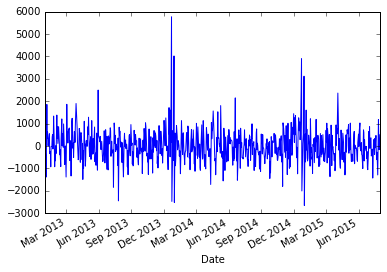

In [11]:
model.resid.plot()

Here we saw large spikes at the end of each year, indicating that our model does not account for holiday spikes. Of course, our models are only related to the last few values in the time series, and don't take into account the longer seasonal pattern.

We can also plot the autocorrelations of the residuals. In an ideal model, these would all nearly be 0 and hopefully random.

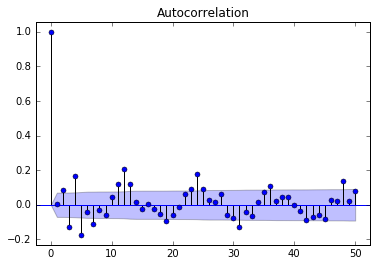

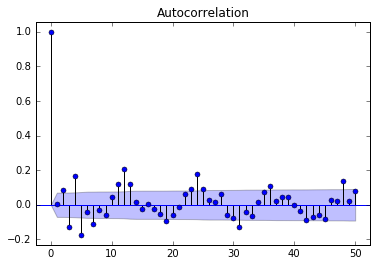

In [12]:
plot_acf(model.resid, lags=50)

This aspect is also troubling - the autocorrelation plot shows a clear pattern where errors are increasing and decreasing every week.

To expand this AR model to a ARMA model, we can include the moving average component as well.

In [13]:
model = ARMA(store1_sales_data, (1, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Thu, 17 Nov 2016   AIC                          12542.222
Time:                        19:41:19   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6335     84.702     56.228      0.000      4596.621  4928.647
ar.L1.Sales     0.6979      0.035     20.095      0.000         0.630     0.766
ma.L1.Sales    -0.0294      0.045     -0.654      0.514        -0.118     0.059
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4328           +0.0000j            1.4328            0.0000
MA.1           34.0019           +0.0000j           34.0019            0.0000
-----------------------------------------------------------------------------
"""

Now we learn two coefficients, one for the AR(1) component and one for the MA(1)

**Check:** Take a moment to look at the coefficients and offer an interpretation.

Remember this is an AR(1) + MA(1) model. So the AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value.

The coefficients here are 0.69 for the AR component and -0.03 for the MA component. The AR coefficient is the same as before (decreasing values) and the MA component is fairly small (which we should have expected from the autocorrelation plots).

### ARIMA models in Statsmodels

To train an ARIMA model in `statsmodels`, we can change the `ARMA` model to `ARIMA` and additionally provide the differencing parameter. To start, we can see that we can train an ARMA(2,2) model by training an ARIMA(2, 0, 2) model.

In [14]:
from statsmodels.tsa.arima_model import ARIMA

In [15]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Thu, 17 Nov 2016   AIC                          12506.358
Time:                        19:43:08   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189        -0.250     1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000        -0.279    -0.085
ar.L2.D.Sales     0.6469      0.035     18.602      0.000         0.579     0.715
ma.L1.D.Sales    -0.1858      0.052     -3.569      0.000        -0.288    -0.084
ma.L2.D.Sales    -0.8142      0.052    -15.659      0.000        -0.916    -0.712
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1106           +0.0000j            1.1106            0.5000
AR.2            1.3920           +0.0000j            1.3920            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.2282           +0.0000j            1.2282            0.5000
-----------------------------------------------------------------------------
"""

In [16]:
# For a moment, let's remove the moving average component since it wasn't particularly useful before.
model = ARIMA(store1_sales_data, (1, 1, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Thu, 17 Nov 2016   AIC                          12633.233
Time:                        19:44:26   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2161     24.028      0.009      0.993       -46.877    47.309
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000        -0.251    -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

This is now an AR(1) model on the differenced data.  We learn a single coefficient of -.18.

**Check:** Does this match the lag 1 autocorrelation of the differenced series? Is the data stationary?

Yes, we can compute the lag 1 auto correlation of the difference series and see if they match

In [17]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

-0.18144101447610667

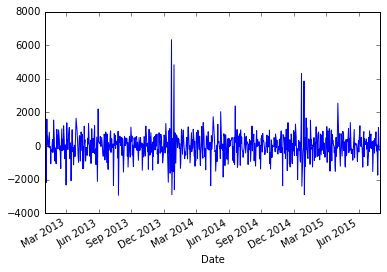

In [18]:
# We can plot it to see the difference.
store1_sales_data.Sales.diff(1).plot()

**Check**: Notice this looks generally true, but the variance is not constant. Why not?

> Answer: It is mostly the same throughout the series except around the holidays.

From our models, we can also plot future predictions and compare them with the true series. To compare our forecast with the true values, we can use the `plot_predict` function.

We can compare the last 50 days of true values and predictions as values:

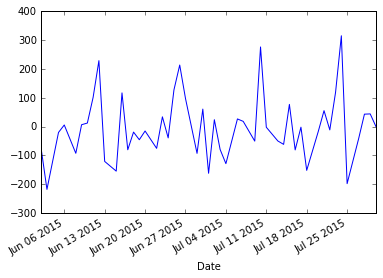

In [23]:
model.predict(1,50).plot()

This function takes two arguments which are the start and end index of the dataframe to plot. Here, we are plotting the last 50 values.

To plot earlier values, with our predictions extended out, we do the following. This plots true values in 2014, and our predictions 200 days out from 2014.

C:\Users\byerj023\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\tsa\arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


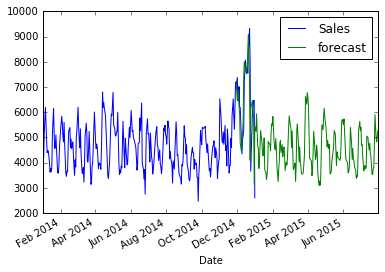

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

Additionally, we can revisit our diagnostics to check if our models are working well.

**Check:** Plot the residuals and autocorrelation of residuals to test that model is working well. Are there patterns or outliers?

The two previous problems remain: large errors around the holiday period and these errors have high autocorrelation.

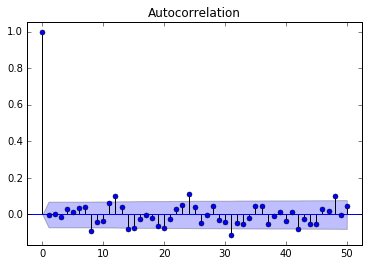

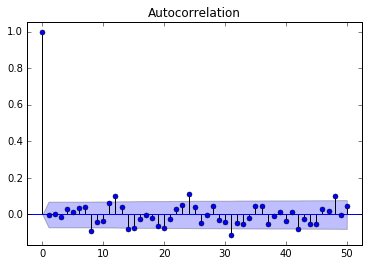

In [25]:
# We can alter the AR model to adjust for a piece of this - increasing the lag to 7.

model = ARIMA(store1_sales_data, (7, 1, 1)).fit()
model.summary()

plot_acf(model.resid, lags=50)

C:\Users\byerj023\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


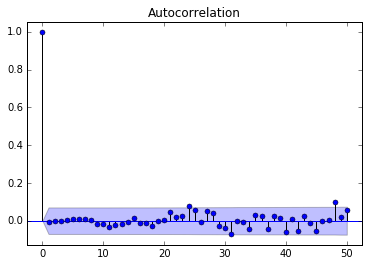

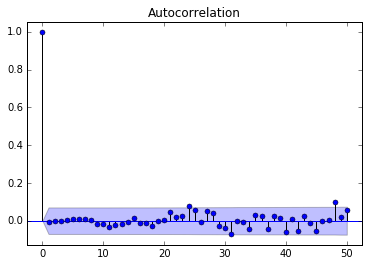

In [35]:
# We can alter the AR model to adjust for a piece of this - increasing the lag to 7.

model = ARIMA(store1_sales_data, (14, 1, 6)).fit()
model.summary()

plot_acf(model.resid, lags=50)

This removes some of the autocorrelation in the residuals, but large discrepancies still exist. However, they exist where we are breaking our model assumptions as well, which is important to keep in mind.

**Check:** Alter the time period of predictions and p, d, q parameters. Do any of these improve the diagnostics? What does changing p and q imply based on the autocorrelation plot? How about d?

After some practice with altering p, q, d - there aren't many models that fix the issue left.

- Increasing p would increase the dependency on previous values further (longer lag), but this isn't necessary past a given point.
- Increasing q would increase the dependency of an unexpected jump at a handful of points, but we did not observe that in our autocorrelation plot.
- Increasing d would increase differencing, but with d=1 we saw a move towards stationarity already (except at a few problematic regions). Increasing to 2 may be useful if we are saw an exponential trend, but that we did not here.

There are variants of ARIMA that will handle the seasonal aspect better, known as Seasonal ARIMA. In short, these models fit two ARIMA models, one of the daily frequency and another on the seasonal frequency (monthly or yearly, whichever the pattern may be).

Issues with seasonality could also be handled by pre-processing tricks such as detrending.